### We will try to solve the basic problem of CartPole balancing using Deep Q-Learning.
It will use neural networks to approximate the Q-function. But, the inputs are not state variables, instead they are directly the images of the game screen. A CNN will be used and a replay memory will be used to store the experiences. All the implementation follows similar to the DQN paper. (Tried this using PyTorch article, but it wasn't working. So using Keras now.)

[https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762](https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762)

#### Q-network
Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing Q(s,left) and Q(s,right) (where s is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

We also use a target network to compute V(s@t+1) for added stability. The target network has its weights kept frozen most of the time, but is updated with the policy network’s weights every so often. This is usually a set number of steps but we shall use episodes for simplicity.

In [1]:
# Import libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import random

In [3]:
# Get cartpole environment from gym
envCartPole = gym.make('CartPole-v1')

In [4]:
EPISODES = 300  # Number of episodes to run for. Training might end before this number is reached.
N_TIMESTEPS = 210  # Number of timesteps per episode.
TRAIN_END = 0  # The episode at which training ends.
DISCOUNT_FACTOR = 0.95  # Gamma, the discount factor.
LEARNING_RATE = 0.001  # For the Adam optimizer
BATCH_SIZE = 24  # Size of the batch to use in experience replay
EPSILON_START = 1  # Starting value for epsilon in the epsilon-greedy policy.
EPSILON_END = 0.001
EPSILON_DECAY = 0.995
REWARD_GOAL = 195

In [7]:
class DeepQNetwork:
    def __init__(self, states, actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    def build_model(self):
        """
        Builds the model used for the Q-network. The model gives predicted action values for the state.
        """
        model = Sequential()  #linear stack of layers https://keras.io/models/sequential/
        model.add(Dense(24, input_dim=self.nS, activation='relu'))  #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(Dense(24, activation='relu'))  #Layer 2 -> 3
        model.add(Dense(self.nA, activation='linear'))  #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error',  #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(learning_rate=self.alpha))
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA)  #Explore
        action_vals = self.model.predict(state)  #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state):  #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample(self.memory, batch_size)  #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0, self.nS))  #States
        nst = np.zeros((0, self.nS))  #Next States
        for i in range(len(np_array)):  #Creating the state and next state np arrays
            st = np.append(st, np_array[i, 0], axis=0)
            nst = np.append(nst, np_array[i, 3], axis=0)
        st_predict = self.model.predict(st)  #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done:  #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:  #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size, self.nS)
        y_reshape = np.array(y)
        epoch_count = 1  #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append(hist.history['loss'][i])
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
# Create the network
nS = envCartPole.observation_space.shape[0]  #This is only 4
nA = envCartPole.action_space.n  #Actions
dqn = DeepQNetwork(nS, nA, LEARNING_RATE, DISCOUNT_FACTOR, EPSILON_START, EPSILON_END, EPSILON_DECAY)

In [9]:
#Training
rewards = []  #Store rewards for graphing
epsilons = []  # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset(seed=50)  # Set the seed to keep the environment consistent across runs
    state = np.reshape(state, [1, nS])  # Resize to store in memory to pass to .predict
    ep_rewards = 0
    for time in range(N_TIMESTEPS):  #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        ep_rewards += reward
        dqn.store(state, action, reward, nstate, done)  # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell.
        #time == 209: CartPole stayed upright
        if done or time == N_TIMESTEPS - 1:
            rewards.append(ep_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, ep_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > BATCH_SIZE:
            dqn.experience_replay(BATCH_SIZE)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > REWARD_GOAL:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

C:\Users\nikhi\AppData\Local\Temp\ipykernel_18276\2477162579.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_array = np.array(minibatch)


episode: 0/500, score: 57.0, e: 0.851801859600347
episode: 1/500, score: 27.0, e: 0.7477194593032545
episode: 2/500, score: 30.0, e: 0.6465587967553006
episode: 3/500, score: 10.0, e: 0.6180388156137953
episode: 4/500, score: 19.0, e: 0.5647174463480732
episode: 5/500, score: 13.0, e: 0.531750826943791
episode: 6/500, score: 12.0, e: 0.5032248303978422
episode: 7/500, score: 13.0, e: 0.4738479773082268
episode: 8/500, score: 14.0, e: 0.4439551321314536
episode: 9/500, score: 11.0, e: 0.4222502236424958
episode: 10/500, score: 10.0, e: 0.4036245882390106
episode: 11/500, score: 10.0, e: 0.3858205374665315
episode: 12/500, score: 12.0, e: 0.36512303261753626
episode: 13/500, score: 10.0, e: 0.34901730169741024
episode: 14/500, score: 10.0, e: 0.33362200135903064
episode: 15/500, score: 13.0, e: 0.3141460853680822
episode: 16/500, score: 12.0, e: 0.29729358661854943
episode: 17/500, score: 11.0, e: 0.2827589419554058
episode: 18/500, score: 13.0, e: 0.2662522686041882
episode: 19/500, sco

In [10]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    ep_rewards = 0
    for t_test in range(N_TIMESTEPS):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        ep_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell.
        #t_test == 209: CartPole stayed upright
        if done or t_test == N_TIMESTEPS - 1:
            rewards.append(ep_rewards)
            epsilons.append(0)  #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, ep_rewards, 0))
            break

episode: 0/405, score: 127.0, e: 0
episode: 1/405, score: 120.0, e: 0
episode: 2/405, score: 124.0, e: 0
episode: 3/405, score: 132.0, e: 0
episode: 4/405, score: 154.0, e: 0
episode: 5/405, score: 134.0, e: 0
episode: 6/405, score: 204.0, e: 0
episode: 7/405, score: 175.0, e: 0
episode: 8/405, score: 128.0, e: 0
episode: 9/405, score: 136.0, e: 0
episode: 10/405, score: 150.0, e: 0
episode: 11/405, score: 210.0, e: 0
episode: 12/405, score: 159.0, e: 0
episode: 13/405, score: 144.0, e: 0
episode: 14/405, score: 138.0, e: 0
episode: 15/405, score: 210.0, e: 0
episode: 16/405, score: 210.0, e: 0
episode: 17/405, score: 148.0, e: 0
episode: 18/405, score: 121.0, e: 0
episode: 19/405, score: 130.0, e: 0
episode: 20/405, score: 131.0, e: 0
episode: 21/405, score: 163.0, e: 0
episode: 22/405, score: 123.0, e: 0
episode: 23/405, score: 130.0, e: 0
episode: 24/405, score: 210.0, e: 0
episode: 25/405, score: 167.0, e: 0
episode: 26/405, score: 210.0, e: 0
episode: 27/405, score: 130.0, e: 0
ep

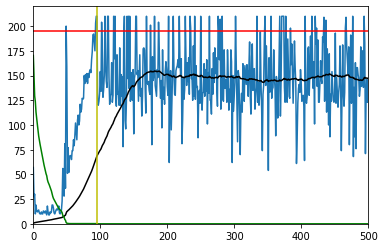

In [11]:
rolling_average = np.convolve(rewards, np.ones(100) / 100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-')  #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200 * x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim((0, EPISODES))
plt.ylim((0, 220))
plt.show()

envCartPole.close()

### Conclusion
Looks like taking the average of last 5 episode rewards is not a good way to determine if we have solved the game. We've to take the average of all the rewards until the current episode. But, this is just a demo of how to use the DQN.